In [ ]:
#| default_exp core

# Semi Random Collection of functions
> eventually to go into dedicated modules

In [ ]:
#| hide
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import numpy as np
import re
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [ ]:
#| export
def convert_palette_to_hex(palette_name, n_colors):
    """
    Convert a named color palette to hex color codes.
    
    Parameters:
    -----------
    palette_name : str
        Name of the palette (e.g., 'tab10', 'Set1', 'husl', 'viridis')
    n_colors : int
        Number of colors to generate
        
    Returns:
    --------
    list
        List of hex color codes
    """

    
    try:
        # Try to get palette from seaborn
        palette = sns.color_palette(palette_name, n_colors)
        hex_colors = [mcolors.rgb2hex(color) for color in palette]
        return hex_colors
    except:
        try:
            # Try as a matplotlib colormap
            cmap = plt.cm.get_cmap(palette_name, n_colors)
            hex_colors = [mcolors.rgb2hex(cmap(i)) for i in range(n_colors)]
            return hex_colors
        except:
            # Fallback to default
            print(f"Palette '{palette_name}' not found, using default.")
            return sns.color_palette("husl", n_colors).as_hex()


In [ ]:
#| export
def create_group_color_mapping(items, group_size=3, palette=None, palette_name=None, return_color_to_group=False):
    """
    Create a color mapping dictionary that assigns the same color to items in groups.
    
    Parameters:
    -----------
    items : list
        List of items to be mapped to colors
    group_size : int
        Number of items to assign to each color (default: 3)
    palette : list or None
        List of colors to use. If None, uses default colors in hex format.
    palette_name : str or None
        Name of a seaborn/matplotlib palette (e.g., 'tab10', 'Set1') to use.
        This is used if palette is None.
    return_color_to_group : bool
        If True, also returns a dictionary mapping colors to group names
        
    Returns:
    --------
    dict or tuple
        Dictionary mapping each item to its assigned color (hex format)
        If return_color_to_group is True, also returns a dict mapping colors to group names
    """
    # Calculate how many colors we need
    num_groups = (len(items) + group_size - 1) // group_size  # Ceiling division
    
    # Generate or use provided color palette in hex format
    if palette is None:
        if palette_name is not None:
            # Use the specified palette name
            colors = convert_palette_to_hex(palette_name, num_groups)
        else:
            # Default hex color palette
            default_colors = [
                '#FF5733', '#33FF57', '#3357FF', '#FF33A8', '#33FFF5', 
                '#FFD133', '#A833FF', '#FF8D33', '#33ACFF', '#FF3352'
            ]
            
            # If we need more colors, generate them
            if num_groups > len(default_colors):
                
                
                # Use seaborn to generate additional colors in hex
                additional_colors = sns.color_palette("husl", num_groups - len(default_colors)).as_hex()
                colors = default_colors + additional_colors
            else:
                colors = default_colors[:num_groups]
    else:
        # Convert any non-hex colors in provided palette to hex format
        
        colors = []
        for color in palette:
            if isinstance(color, str) and color.startswith('#'):
                colors.append(color)
            else:
                try:
                    colors.append(mcolors.to_hex(color))
                except:
                    colors.append('#888888')  # Default gray if conversion fails
        
        # If palette is too small, cycle it
        if len(colors) < num_groups:
            colors = colors * (num_groups // len(colors) + 1)
        
        colors = colors[:num_groups]
    
    # Create the mapping dictionary
    color_mapping = {}
    # If requested, also create a mapping from color to group name
    color_to_group = {}
    
    for i, item in enumerate(items):
        group_idx = i // group_size
        group_name = f"Group {group_idx + 1}"
        color_idx = min(group_idx, len(colors) - 1)  # Ensure we don't go out of bounds
        color = colors[color_idx]
        
        color_mapping[item] = color
        
        # Add to color_to_group dictionary if it doesn't exist yet
        if return_color_to_group and color not in color_to_group:
            color_to_group[color] = group_name
    
    if return_color_to_group:
        return color_mapping, color_to_group
    else:
        return color_mapping



In [ ]:

# Example usage with different palette options
def demonstrate_group_mapping_palettes():
    # Create a list of items
    items = [f'gene_{i}' for i in range(15)]
    
    # Create a figure with multiple palette examples
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))
    
    # Example 1: Default palette
    color_map1, group_map1 = create_group_color_mapping(
        items, group_size=3, return_color_to_group=True
    )
    
    # Example 2: tab10 palette
    color_map2, group_map2 = create_group_color_mapping(
        items, group_size=3, palette_name='tab10', return_color_to_group=True
    )
    
    # Example 3: Set2 palette
    color_map3, group_map3 = create_group_color_mapping(
        items, group_size=3, palette_name='Set2', return_color_to_group=True
    )
    
    # Example 4: viridis palette
    color_map4, group_map4 = create_group_color_mapping(
        items, group_size=3, palette_name='viridis', return_color_to_group=True
    )
    
    # Plot all examples
    palettes = [
        ('Default Palette', color_map1, group_map1),
        ('tab10 Palette', color_map2, group_map2),
        ('Set2 Palette', color_map3, group_map3),
        ('viridis Palette', color_map4, group_map4)
    ]
    
    for i, (title, color_map, group_map) in enumerate(palettes):
        ax = axes[i]
        
        # Plot bars
        for j, item in enumerate(items):
            ax.barh(0, 0.8, left=j, height=0.8, color=color_map[item], alpha=0.7)
            if i == 0:  # Only add labels on the first plot
                ax.text(j+0.4, 0, item, rotation=90, ha='center', va='bottom')
        
        # Add legend
        
        legend_elements = [Patch(facecolor=color, label=group) for color, group in group_map.items()]
        ax.legend(handles=legend_elements, loc='upper center', ncol=len(group_map))
        
        ax.set_ylim(-0.5, 0.5)
        ax.set_xlim(-0.5, len(items) - 0.5)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(title)
    
    plt.tight_layout()
    
    # Print example of hex colors from tab10
    print("Example hex colors from tab10 palette:")
    for color in list(group_map2.keys())[:5]:
        print(color)
    
    return fig, axes

Example hex colors from tab10 palette:
#1f77b4
#ff7f0e
#2ca02c
#d62728
#9467bd


(<Figure size 864x720 with 4 Axes>,
 array([<Axes: title={'center': 'Default Palette'}>,
        <Axes: title={'center': 'tab10 Palette'}>,
        <Axes: title={'center': 'Set2 Palette'}>,
        <Axes: title={'center': 'viridis Palette'}>], dtype=object))

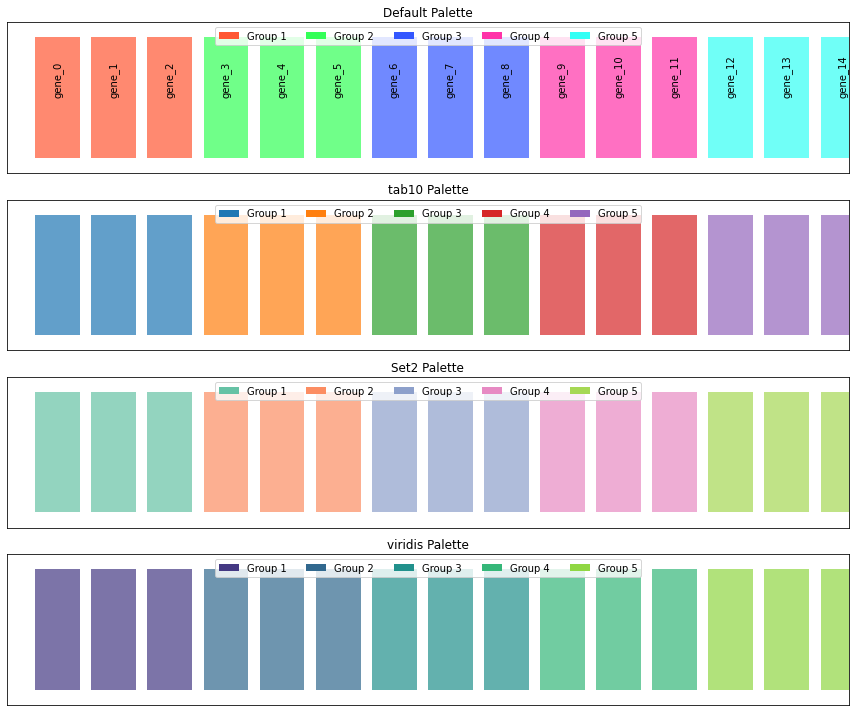

In [ ]:
demonstrate_group_mapping_palettes()

In [ ]:
#| export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def norm_loading(df):
    '''
    Normalize datasets by equalizing the medians of all columns to a common target value.
    
    This function implements a median normalization strategy that:
    1. Calculates the median value for each column in the input dataframe
    2. Computes a target value (the mean of all column medians)
    3. Derives normalization factors to adjust each column to the target median
    4. Applies these normalization factors to create a normalized dataset
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe where:
        - Each column represents a sample/replicate
        - Each row represents a feature/variable (e.g., protein, gene, metabolite)
        
    Returns:
    --------
    pandas.DataFrame
        Normalized dataframe with the same dimensions as the input,
        where all columns have approximately the same median value
    '''
    # Calculate the median of each column
    medians = df.median(axis=0)
    print('medians', np.array(medians))
    
    # Compute target value (the mean of all column medians)
    # This becomes our reference point to normalize all columns
    target = np.mean(medians)
    print('target', target)
    
    # Calculate normalization factors for each column
    # Columns with medians below the target will be scaled up (norm_fac > 1)
    # Columns with medians above the target will be scaled down (norm_fac < 1)
    norm_facs = target / medians
    print('norm_facs', np.array(norm_facs))
    
    # Apply normalization factors to each column
    # This preserves relative differences within each column while
    # equalizing the median values across all columns
    data_norm = df.multiply(norm_facs, axis=1)
    
    return data_norm



medians [ 96.82609271  96.6821434   92.14930633 151.50472099 157.87481208
 151.45188746]
target 124.41482716043556
norm_facs [1.28493078 1.28684391 1.35014394 0.82119439 0.78806002 0.82148086]


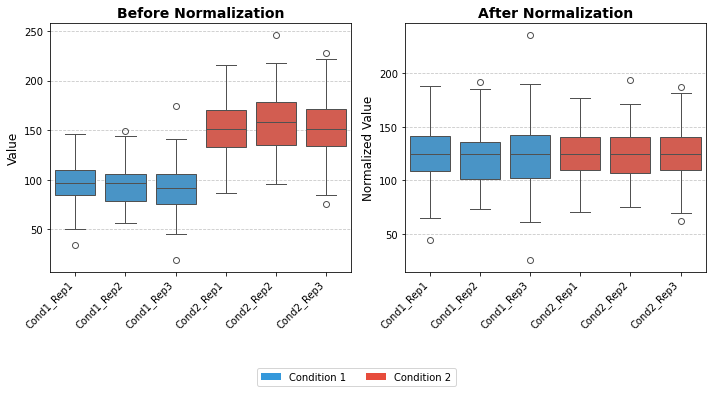

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data with controlled medians
# Creating a dataset with 100 features (rows) and 6 samples (columns)
# - 3 replicates for condition 1 (lower median)
# - 3 replicates for condition 2 (higher median)

# Number of features (e.g., proteins, genes)
n_features = 100

# Create condition 1 data (3 replicates with similar distribution)
condition1_rep1 = np.random.normal(loc=100, scale=25, size=n_features)
condition1_rep2 = np.random.normal(loc=95, scale=20, size=n_features)
condition1_rep3 = np.random.normal(loc=90, scale=22, size=n_features)

# Create condition 2 data (3 replicates with higher median)
condition2_rep1 = np.random.normal(loc=150, scale=30, size=n_features)
condition2_rep2 = np.random.normal(loc=160, scale=28, size=n_features)
condition2_rep3 = np.random.normal(loc=155, scale=32, size=n_features)

# Create a DataFrame
data = pd.DataFrame({
    'Cond1_Rep1': condition1_rep1,
    'Cond1_Rep2': condition1_rep2,
    'Cond1_Rep3': condition1_rep3,
    'Cond2_Rep1': condition2_rep1,
    'Cond2_Rep2': condition2_rep2,
    'Cond2_Rep3': condition2_rep3
})

# Apply the normalization function
data_normalized = norm_loading(data)

# Set up the figure for visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Color mapping for conditions
colors = ['#3498db', '#e74c3c']  # Blue for Condition 1, Red for Condition 2
condition_colors = {
    'Cond1_Rep1': colors[0], 'Cond1_Rep2': colors[0], 'Cond1_Rep3': colors[0],
    'Cond2_Rep1': colors[1], 'Cond2_Rep2': colors[1], 'Cond2_Rep3': colors[1]
}

# 1. Boxplot for raw data (before normalization)
ax1.set_title('Before Normalization', fontsize=14, fontweight='bold')
sns.boxplot(data=data, ax=ax1, palette=condition_colors)
# Get current tick positions
ax1_ticks = ax1.get_xticks()
ax1_labels = [label.get_text() for label in ax1.get_xticklabels()]
# Set ticks and then ticklabels
ax1.set_xticks(ax1_ticks)
ax1.set_xticklabels(ax1_labels, rotation=45, ha='right')
ax1.set_ylabel('Value', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Boxplot for normalized data
ax2.set_title('After Normalization', fontsize=14, fontweight='bold')
sns.boxplot(data=data_normalized, ax=ax2, palette=condition_colors)
# Get current tick positions
ax2_ticks = ax2.get_xticks()
ax2_labels = [label.get_text() for label in ax2.get_xticklabels()]
# Set ticks and then ticklabels
ax2.set_xticks(ax2_ticks)
ax2.set_xticklabels(ax2_labels, rotation=45,ha='right')
ax2.set_ylabel('Normalized Value', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)


# Create a custom legend for conditions
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors[0], label='Condition 1'),
    Patch(facecolor=colors[1], label='Condition 2')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=2)

# Adjust layout to make room for annotations
plt.tight_layout(rect=[0, 0.1, 1, 0.9])
plt.show()

In [ ]:
#| export
def quantileNormalize(df_input, keep_na=True):
    """
    Perform quantile normalization on a pandas DataFrame.
    
    Quantile normalization is a technique that makes the distribution of values
    for each column identical by transforming the values to match the distribution
    of the mean of quantiles across all columns.
    
    Algorithm:
    1. Sort values in each column independently
    2. Calculate the mean across rows of the sorted data (creating a reference distribution)
    3. For each original value, assign the corresponding value from the reference distribution
       based on its rank in its original column
    
    Parameters:
    -----------
    df_input : pandas.DataFrame
        Input dataframe where:
        - Each column represents a sample/variable
        - Each row represents an observation/feature
    
    keep_na : bool, default=True
        If True, preserves NaN values in the original data
        If False, NaN values will be assigned a normalized value
    
    Returns:
    --------
    pandas.DataFrame
        Normalized dataframe with the same shape as the input, where
        all columns have identical distributions
    
    """
    # Create a copy of the input dataframe to avoid modifying the original
    df = df_input.copy()
    
    # Step 1: Sort values in each column and store in a dictionary
    dic = {}
    for col in df:
        dic.update({col: sorted(df[col])})
    
    # Create a dataframe from the sorted values
    sorted_df = pd.DataFrame(dic)
    
    # Step 2: Calculate the mean across each row to create the reference distribution
    # This represents the average quantile values across all columns
    rank = sorted_df.mean(axis=1).tolist()
    
    # Step 3: Map each value in the original dataframe to its corresponding value
    # in the reference distribution based on its rank
    for col in df:
        # Find the rank of each value in the original column
        # np.searchsorted returns indices where original values would be inserted
        # into the sorted array to maintain order
        t = np.searchsorted(np.sort(df[col]), df[col])
        
        # Assign the corresponding value from the reference distribution
        norm = [rank[i] for i in t]
        
        # Preserve NaN values if keep_na is True
        if keep_na == True:
            # Replace normalized values with NaN where original values were NaN
            norm = [np.nan if np.isnan(a) else b for a, b in zip(df[col], norm)]
        
        # Update the column with normalized values
        df[col] = norm
    
    return df

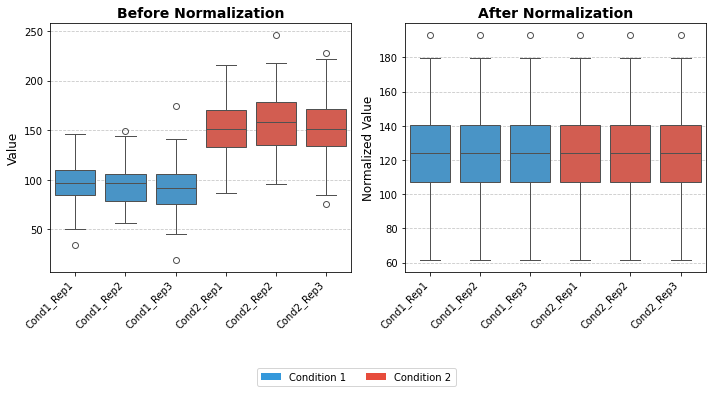

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data with controlled medians
# Creating a dataset with 100 features (rows) and 6 samples (columns)
# - 3 replicates for condition 1 (lower median)
# - 3 replicates for condition 2 (higher median)

# Number of features (e.g., proteins, genes)
n_features = 100

# Create condition 1 data (3 replicates with similar distribution)
condition1_rep1 = np.random.normal(loc=100, scale=25, size=n_features)
condition1_rep2 = np.random.normal(loc=95, scale=20, size=n_features)
condition1_rep3 = np.random.normal(loc=90, scale=22, size=n_features)

# Create condition 2 data (3 replicates with higher median)
condition2_rep1 = np.random.normal(loc=150, scale=30, size=n_features)
condition2_rep2 = np.random.normal(loc=160, scale=28, size=n_features)
condition2_rep3 = np.random.normal(loc=155, scale=32, size=n_features)

# Create a DataFrame
data = pd.DataFrame({
    'Cond1_Rep1': condition1_rep1,
    'Cond1_Rep2': condition1_rep2,
    'Cond1_Rep3': condition1_rep3,
    'Cond2_Rep1': condition2_rep1,
    'Cond2_Rep2': condition2_rep2,
    'Cond2_Rep3': condition2_rep3
})

# Apply the normalization function
data_normalized = quantileNormalize(data)

# Set up the figure for visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Color mapping for conditions
colors = ['#3498db', '#e74c3c']  # Blue for Condition 1, Red for Condition 2
condition_colors = {
    'Cond1_Rep1': colors[0], 'Cond1_Rep2': colors[0], 'Cond1_Rep3': colors[0],
    'Cond2_Rep1': colors[1], 'Cond2_Rep2': colors[1], 'Cond2_Rep3': colors[1]
}

# 1. Boxplot for raw data (before normalization)
ax1.set_title('Before Normalization', fontsize=14, fontweight='bold')
sns.boxplot(data=data, ax=ax1, palette=condition_colors)
# Get current tick positions
ax1_ticks = ax1.get_xticks()
ax1_labels = [label.get_text() for label in ax1.get_xticklabels()]
# Set ticks and then ticklabels
ax1.set_xticks(ax1_ticks)
ax1.set_xticklabels(ax1_labels, rotation=45, ha='right')
ax1.set_ylabel('Value', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Boxplot for normalized data
ax2.set_title('After Normalization', fontsize=14, fontweight='bold')
sns.boxplot(data=data_normalized, ax=ax2, palette=condition_colors)
# Get current tick positions
ax2_ticks = ax2.get_xticks()
ax2_labels = [label.get_text() for label in ax2.get_xticklabels()]
# Set ticks and then ticklabels
ax2.set_xticks(ax2_ticks)
ax2.set_xticklabels(ax2_labels, rotation=45,ha='right')
ax2.set_ylabel('Normalized Value', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)


# Create a custom legend for conditions
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors[0], label='Condition 1'),
    Patch(facecolor=colors[1], label='Condition 2')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=2)

# Adjust layout to make room for annotations
plt.tight_layout(rect=[0, 0.1, 1, 0.9])
plt.show()

In [ ]:
#| export
def norm_loading_TMT(df):
    """
    Normalize TMT (Tandem Mass Tag) proteomics data to account for uneven sample loading.
    
    This function performs total sum normalization, specifically designed for 
    TMT-based multiplexed proteomics experiments where differences in total 
    protein abundance between samples may be due to technical variations rather
    than biological differences.
    
    Background:
    -----------
    In TMT proteomics experiments, multiple samples are labeled with different 
    isobaric tags and measured simultaneously. However, variations in:
      - Sample preparation
      - Protein extraction efficiency
      - Peptide/protein loading
      - Labeling efficiency
    can lead to systematic biases that affect all proteins within a sample.
    
    Algorithm:
    ----------
    1. Calculate the sum of all protein abundances for each sample (column)
    2. Compute a target value (mean of all column sums)
    3. Calculate normalization factors for each sample
    4. Scale each sample by its corresponding normalization factor
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe where:
        - Rows represent proteins or peptides
        - Columns represent TMT channels/samples
        - Values are intensity/abundance measurements
    
    Returns:
    --------
    pandas.DataFrame
        Normalized dataframe with the same dimensions as the input,
        where each sample's total protein abundance is equalized
    
    Notes:
    ------
    - This normalization assumes that differences in total protein abundance
      between samples are due to technical variation, not biological differences
    - This method is preferable to median normalization for TMT data because it
      accounts for the total reporter ion signal in each channel
    - For samples where biological differences in total protein content are
      expected, alternative normalization strategies should be considered
    """
    # Calculate the sum of all values in each column (total protein per sample)
    # This represents the total reporter ion signal in each TMT channel
    col_sum = df.sum(axis=0)
    # print(col_sum)
    
    # Calculate the target value (average of all sample totals)
    # This becomes our reference point to normalize all samples
    target = np.mean(col_sum)
    # print(target)
    
    # Calculate normalization factors for each sample
    # Samples with lower total protein will get scaled up (norm_fac > 1)
    # Samples with higher total protein will get scaled down (norm_fac < 1)
    norm_facs = target / col_sum
    # print(norm_facs)
    
    # Apply normalization factors to each sample (column)
    # This preserves relative protein abundances within each sample
    # while equalizing the total protein content across all samples
    data_norm = df.multiply(norm_facs, axis=1)
    
    return data_norm

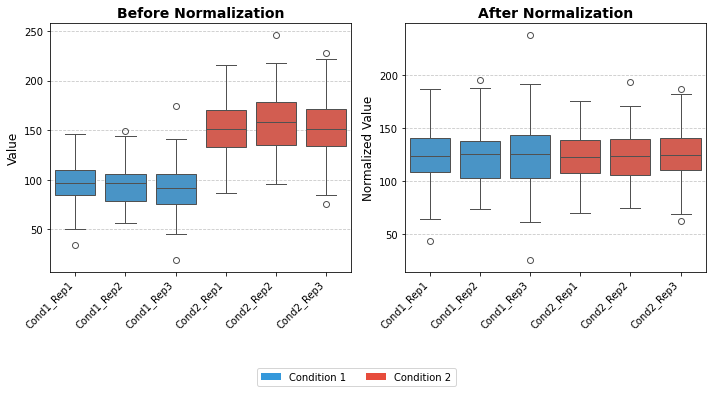

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data with controlled medians
# Creating a dataset with 100 features (rows) and 6 samples (columns)
# - 3 replicates for condition 1 (lower median)
# - 3 replicates for condition 2 (higher median)

# Number of features (e.g., proteins, genes)
n_features = 100

# Create condition 1 data (3 replicates with similar distribution)
condition1_rep1 = np.random.normal(loc=100, scale=25, size=n_features)
condition1_rep2 = np.random.normal(loc=95, scale=20, size=n_features)
condition1_rep3 = np.random.normal(loc=90, scale=22, size=n_features)

# Create condition 2 data (3 replicates with higher median)
condition2_rep1 = np.random.normal(loc=150, scale=30, size=n_features)
condition2_rep2 = np.random.normal(loc=160, scale=28, size=n_features)
condition2_rep3 = np.random.normal(loc=155, scale=32, size=n_features)

# Create a DataFrame
data = pd.DataFrame({
    'Cond1_Rep1': condition1_rep1,
    'Cond1_Rep2': condition1_rep2,
    'Cond1_Rep3': condition1_rep3,
    'Cond2_Rep1': condition2_rep1,
    'Cond2_Rep2': condition2_rep2,
    'Cond2_Rep3': condition2_rep3
})

# Apply the normalization function
data_normalized = norm_loading_TMT(data)

# Set up the figure for visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Color mapping for conditions
colors = ['#3498db', '#e74c3c']  # Blue for Condition 1, Red for Condition 2
condition_colors = {
    'Cond1_Rep1': colors[0], 'Cond1_Rep2': colors[0], 'Cond1_Rep3': colors[0],
    'Cond2_Rep1': colors[1], 'Cond2_Rep2': colors[1], 'Cond2_Rep3': colors[1]
}

# 1. Boxplot for raw data (before normalization)
ax1.set_title('Before Normalization', fontsize=14, fontweight='bold')
sns.boxplot(data=data, ax=ax1, palette=condition_colors)
# Get current tick positions
ax1_ticks = ax1.get_xticks()
ax1_labels = [label.get_text() for label in ax1.get_xticklabels()]
# Set ticks and then ticklabels
ax1.set_xticks(ax1_ticks)
ax1.set_xticklabels(ax1_labels, rotation=45, ha='right')
ax1.set_ylabel('Value', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Boxplot for normalized data
ax2.set_title('After Normalization', fontsize=14, fontweight='bold')
sns.boxplot(data=data_normalized, ax=ax2, palette=condition_colors)
# Get current tick positions
ax2_ticks = ax2.get_xticks()
ax2_labels = [label.get_text() for label in ax2.get_xticklabels()]
# Set ticks and then ticklabels
ax2.set_xticks(ax2_ticks)
ax2.set_xticklabels(ax2_labels, rotation=45,ha='right')
ax2.set_ylabel('Normalized Value', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)


# Create a custom legend for conditions
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors[0], label='Condition 1'),
    Patch(facecolor=colors[1], label='Condition 2')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=2)

# Adjust layout to make room for annotations
plt.tight_layout(rect=[0, 0.1, 1, 0.9])
plt.show()

In [ ]:
#| export
def ires_norm(df, exps_columns):
    """
    Implement Internal Reference Scaling (IRS) normalization for combining multiple TMT experiments.
    
    This function normalizes and integrates data from multiple TMT experiments by:
    1. Computing the sum of each protein's intensity across all channels within each experiment
    2. Calculating the geometric mean of these sums across experiments (reference value)
    3. Deriving scaling factors to adjust each experiment to this reference
    4. Applying an additional total sum normalization to the combined dataset
    
    Background:
    -----------
    When analyzing multiple TMT experiments (plexes), systematic biases can exist between 
    runs that make direct comparison challenging. IRS normalization uses common proteins 
    across experiments as internal references to make data comparable across these 
    different multiplexed runs.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe where:
        - Rows represent proteins or peptides
        - Columns include all TMT channels from all experiments
        - Values are intensity/abundance measurements
    
    exps_columns : list of lists
        A list containing lists of column names for each experiment
        Example: [[TMT1_126, TMT1_127, ...], [TMT2_126, TMT2_127, ...]]
        Each sublist contains all the TMT channel names for one experiment
    
    Returns:
    --------
    pandas.DataFrame
        Normalized and integrated dataframe combining all experiments, where:
        - Inter-experiment biases have been corrected
        - Total loading has been normalized
    
    Notes:
    ------
    - Missing values (NaN) should be handled before using this function
      (e.g., by imputation or replacing with means)
    - After normalization, you may want to restore original missing values
    - A small constant (1e-8) is added to avoid log(0) issues
    - This implementation combines the IRS approach with total sum normalization
    
    Example:
    --------
    irs_df = ires_norm(df.replace(0, np.nan).fillna(df.mean()), [tmt10_cols, tmt6_cols])
    # Restore original missing values after normalization
    irs_df[df.replace(0, np.nan).isna()] = np.nan
    """
    
    # Check if the DataFrame contains all required columns
    if not all(col in df.columns for cols in exps_columns for col in cols):
        raise ValueError("DataFrame does not contain all the required columns")
    
    # Create a list of DataFrames, one for each experiment
    df_list = [df[exp_cols] for exp_cols in exps_columns]
    
    # Calculate the row sum for each experiment (total protein abundance across channels)
    # This represents the total abundance of each protein in each experiment
    df_sums = pd.concat([exp.sum(axis=1, skipna=True) for exp in df_list], axis=1)
    df_sums.columns = [f'exp_{n+1}' for n in range(len(exps_columns))]
    
    # Compute geometric mean of sums across experiments
    # This serves as our reference value for each protein across all experiments
    # Add a small constant (1e-8) for numerical stability to avoid log(0) issues
    df_sums["gmean"] = np.exp(np.nanmean(np.log(df_sums + 1e-8), axis=1))
    
    # Calculate and apply scaling factors for each experiment
    for n, exp_cols in enumerate(exps_columns):
        # Create column name for the scaling factor
        scaling_col = f'exp_{n+1}_scaling'
        
        # Calculate scaling factor: geometric mean / experiment sum
        # This factor will adjust each experiment to match the reference level
        df_sums[scaling_col] = df_sums["gmean"] / df_sums[f'exp_{n+1}']
        
        # Apply scaling factor to all channels in the experiment
        # This preserves relative abundances within each experiment
        # while making absolute values comparable across experiments
        df_list[n] = df_list[n].multiply(df_sums[scaling_col].values, axis=0)
    
    # Combine all normalized experiments into a single DataFrame
    final_df = pd.concat(df_list, axis=1)
    
    # Apply additional total sum normalization to correct for loading differences
    # across all samples in the combined dataset
    # final_df = norm_loading_TMT(final_df)
    
    return final_df

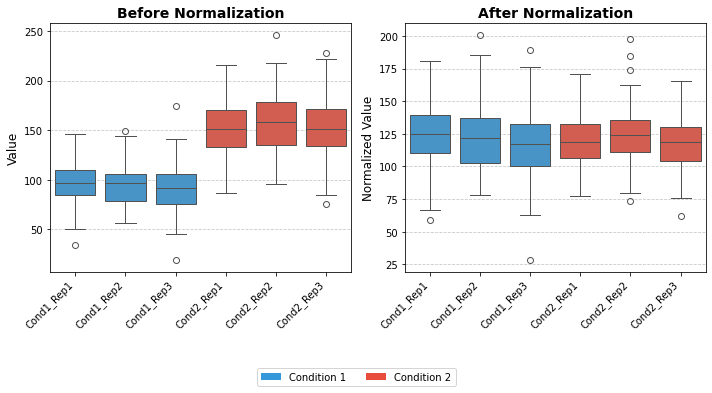

In [ ]:

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data with controlled medians
# Creating a dataset with 100 features (rows) and 6 samples (columns)
# - 3 replicates for condition 1 (lower median)
# - 3 replicates for condition 2 (higher median)

# Number of features (e.g., proteins, genes)
n_features = 100

# Create condition 1 data (3 replicates with similar distribution)
condition1_rep1 = np.random.normal(loc=100, scale=25, size=n_features)
condition1_rep2 = np.random.normal(loc=95, scale=20, size=n_features)
condition1_rep3 = np.random.normal(loc=90, scale=22, size=n_features)

# Create condition 2 data (3 replicates with higher median)
condition2_rep1 = np.random.normal(loc=150, scale=30, size=n_features)
condition2_rep2 = np.random.normal(loc=160, scale=28, size=n_features)
condition2_rep3 = np.random.normal(loc=155, scale=32, size=n_features)

# Create a DataFrame
data = pd.DataFrame({
    'Cond1_Rep1': condition1_rep1,
    'Cond1_Rep2': condition1_rep2,
    'Cond1_Rep3': condition1_rep3,
    'Cond2_Rep1': condition2_rep1,
    'Cond2_Rep2': condition2_rep2,
    'Cond2_Rep3': condition2_rep3
})

# Apply the normalization function
data_normalized = ires_norm(data,[['Cond1_Rep1','Cond1_Rep2','Cond1_Rep3' ],['Cond2_Rep1','Cond2_Rep2','Cond2_Rep3' ]])

# Set up the figure for visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Color mapping for conditions
colors = ['#3498db', '#e74c3c']  # Blue for Condition 1, Red for Condition 2
condition_colors = {
    'Cond1_Rep1': colors[0], 'Cond1_Rep2': colors[0], 'Cond1_Rep3': colors[0],
    'Cond2_Rep1': colors[1], 'Cond2_Rep2': colors[1], 'Cond2_Rep3': colors[1]
}

# 1. Boxplot for raw data (before normalization)
ax1.set_title('Before Normalization', fontsize=14, fontweight='bold')
sns.boxplot(data=data, ax=ax1, palette=condition_colors)
# Get current tick positions
ax1_ticks = ax1.get_xticks()
ax1_labels = [label.get_text() for label in ax1.get_xticklabels()]
# Set ticks and then ticklabels
ax1.set_xticks(ax1_ticks)
ax1.set_xticklabels(ax1_labels, rotation=45, ha='right')
ax1.set_ylabel('Value', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Boxplot for normalized data
ax2.set_title('After Normalization', fontsize=14, fontweight='bold')
sns.boxplot(data=data_normalized, ax=ax2, palette=condition_colors)
# Get current tick positions
ax2_ticks = ax2.get_xticks()
ax2_labels = [label.get_text() for label in ax2.get_xticklabels()]
# Set ticks and then ticklabels
ax2.set_xticks(ax2_ticks)
ax2.set_xticklabels(ax2_labels, rotation=45,ha='right')
ax2.set_ylabel('Normalized Value', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)


# Create a custom legend for conditions
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors[0], label='Condition 1'),
    Patch(facecolor=colors[1], label='Condition 2')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=2)

# Adjust layout to make room for annotations
plt.tight_layout(rect=[0, 0.1, 1, 0.9])
plt.show()

In [ ]:
#| export
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')>2:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    return temp_id

In [ ]:
#| export
def mod_hist_legend(ax, title=False):
    """
    Creates a cleaner legend for histogram plots by using line elements instead of patches.
    when using step
    Motivation:
    - Default histogram legends show rectangle patches which can be visually distracting
    - This function creates a more elegant legend with simple lines matching histogram edge colors
    - Positions the legend outside the plot to avoid overlapping with data
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes object containing the histogram(s)
    title : str or bool, default=False
        Optional title for the legend. If False, no title is displayed
        
    Returns:
    --------
    None - modifies the axes object in place
    """
    # Extract the current handles and labels from the plot
    handles, labels = ax.get_legend_handles_labels()
    
    # Create new line handles that match the edge colors of histogram bars
    # This produces a cleaner, more minimal legend appearance
    new_handles = [matplotlib.lines.Line2D([], [], c=h.get_edgecolor()) for h in handles]
    
    # Create the legend with custom positioning
    # - Places legend outside the plot (to the right) to avoid obscuring the data
    # - Centers the legend vertically for better visual balance
    ax.legend(handles=new_handles, 
              labels=labels, 
              title=title,
              loc='center left', 
              bbox_to_anchor=(1, 0.5))

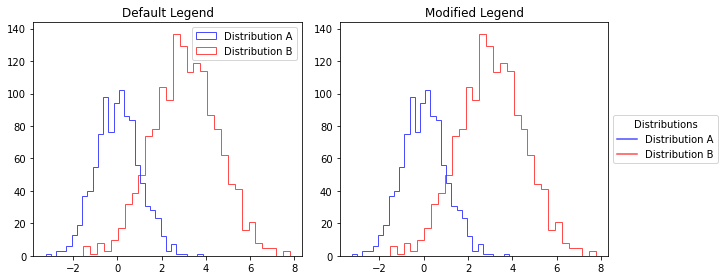

In [ ]:
# Create sample data for multiple distributions
np.random.seed(42)  # For reproducibility
data_a = np.random.normal(0, 1, 1000)
data_b = np.random.normal(3, 1.5, 1500)

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Left subplot: Default histogram legend
ax1.hist(data_a, bins=30, alpha=0.7, label='Distribution A', edgecolor='blue', histtype='step')
ax1.hist(data_b, bins=30, alpha=0.7, label='Distribution B', edgecolor='red', histtype='step')
ax1.set_title('Default Legend')
ax1.legend()  # Default legend

# Right subplot: Modified histogram legend
ax2.hist(data_a, bins=30, alpha=0.7, label='Distribution A', edgecolor='blue', histtype='step')
ax2.hist(data_b, bins=30, alpha=0.7, label='Distribution B', edgecolor='red', histtype='step')
ax2.set_title('Modified Legend')
mod_hist_legend(ax2, title='Distributions')  # Apply our function

# Adjust layout to give space for the right-side legend
plt.tight_layout()
fig.subplots_adjust(right=0.85)

# Display the figure
plt.show()

In [ ]:
#| export
def clean_axes(ax, offset=10):
    """
    Customizes a matplotlib axes by removing top and right spines,
    and creating a broken axis effect where x and y axes don't touch.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes object to customize
    offset : int, default=10
        The amount of offset/gap between the x and y axes in points
        
    Returns:
    --------
    ax : matplotlib.axes.Axes
        The same axes object, modified in place
    """
    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Make the remaining spines gray for a more subtle look
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    
    # Create the broken axis effect
    # Move the bottom spine up by offset points
    #ax.spines['bottom'].set_position(('outward', offset))
    
    # Move the left spine right by offset points
    ax.spines['left'].set_position(('outward', offset))
    
    # Return the modified axes
    return ax

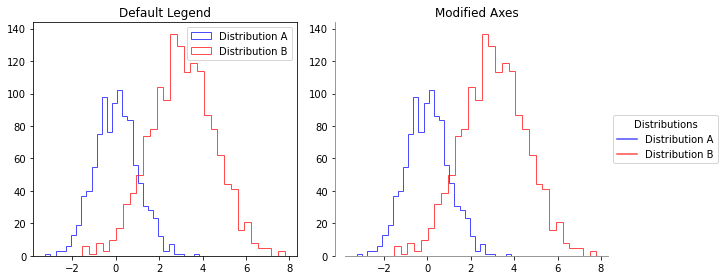

In [ ]:
# Create sample data for multiple distributions
np.random.seed(42)  # For reproducibility
data_a = np.random.normal(0, 1, 1000)
data_b = np.random.normal(3, 1.5, 1500)

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Left subplot: Default histogram legend
ax1.hist(data_a, bins=30, alpha=0.7, label='Distribution A', edgecolor='blue', histtype='step')
ax1.hist(data_b, bins=30, alpha=0.7, label='Distribution B', edgecolor='red', histtype='step')
ax1.set_title('Default Legend')
ax1.legend()  # Default legend

# Right subplot: Modified histogram legend
ax2.hist(data_a, bins=30, alpha=0.7, label='Distribution A', edgecolor='blue', histtype='step')
ax2.hist(data_b, bins=30, alpha=0.7, label='Distribution B', edgecolor='red', histtype='step')
ax2.set_title('Modified Axes')
mod_hist_legend(ax2, title='Distributions')  # Apply our function
clean_axes(ax2)
# Adjust layout to give space for the right-side legend
plt.tight_layout()
fig.subplots_adjust(right=0.85)

# Display the figure
plt.show()

In [ ]:
#| export
def parse_fasta_file(fasta_file):
    '''
    create a dictionary of protein id to gene product
    using fasta file from tritrypDB
    '''
    protein_dict = {}
    current_protein_id = None

    with open(fasta_file, 'r') as f:
        for line in f:
            if line.startswith('>'):
                protein_id = '.'.join(line.split('>')[1].split('.')[0:-3]).split(':')[0]
                gene_product_match = re.search(r'gene_product=([^|]+)', line)

                if  gene_product_match:
                    #protein_id = protein_id_match.group(1)
                    gene_product = gene_product_match.group(1)
                    protein_dict[protein_id] = gene_product.strip()
                    current_protein_id = protein_id
                else:
                    current_protein_id = None
    return protein_dict

def add_desc(data, prot_to_desc):
    desc = []
    for item in data.index.values:
        item_desc = []
        for prot in item.split(';'):
            clean_prot = prot.split(':')[0]
            item_desc.append(prot_to_desc.get(clean_prot,clean_prot))
        item_desc = ';'.join(item_desc)
        desc.append(item_desc)                        
    return desc

In [ ]:
#| export


def get_scaled_df(df):
    scaler = StandardScaler()
    tmp_df = np.log10(df).dropna().copy()
    tmp_df.index = [n .split(':') [0] for n in tmp_df.index.values]
    tmp_df = pd.DataFrame(scaler.fit_transform(tmp_df),
                          index=tmp_df.index,columns=tmp_df.columns)
    return tmp_df


In [ ]:
#| export
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def kmeans_cluster_analysis(df, cluster_sizes, random_state=42, features=None, figsize=(12, 6), 
                          standardize=False, fill_na=False):
    """
    Perform K-means clustering analysis on a pandas DataFrame and visualize the results
    with both normalized inertia and silhouette scores on the same plot.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The input data to cluster.
    cluster_sizes : list
        List of cluster sizes (k values) to evaluate.
    random_state : int, optional
        Random seed for reproducibility (default: 42).
    features : list, optional
        List of column names to use for clustering. If None, all columns are used.
    figsize : tuple, optional
        Figure size for the output plot (default: (12, 6)).
    standardize : bool, optional
        Whether to standardize the features (default: False).
    fill_na : bool, optional
        Whether to fill missing values with column means (default: False).
        
    Returns
    -------
    tuple
        (figure, inertia_values, silhouette_values) - The matplotlib figure object,
        the list of inertia values, and the list of silhouette scores.
    """
    # Prepare the data
    if features is None:
        features = df.columns.tolist()
    
    X = df[features].copy()
    
    # Check for non-numeric data
    non_numeric_cols = X.select_dtypes(exclude=['number']).columns.tolist()
    if non_numeric_cols:
        raise ValueError(f"Non-numeric columns found: {non_numeric_cols}. "
                         f"Please remove or transform them before clustering.")
    
    # Handle missing values
    if X.isna().any().any():
        if fill_na:
            print("Filling missing values with column means.")
            X = X.fillna(X.mean())
        else:
            raise ValueError("Missing values found in the data. Set fill_na=True to automatically handle them or preprocess your data before clustering.")
    
    # Prepare data for clustering
    if standardize:
        print("Standardizing features.")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X.values
    
    # Compute K-means for different cluster sizes
    inertia_values = []
    silhouette_values = []
    
    for k in cluster_sizes:
        # Fit K-means
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        kmeans.fit(X_scaled)
        inertia_values.append(kmeans.inertia_)
        
        # Compute silhouette score (not defined for k=1)
        if k > 1:
            labels = kmeans.labels_
            silhouette_avg = silhouette_score(X_scaled, labels)
            silhouette_values.append(silhouette_avg)
        else:
            silhouette_values.append(0)  # Placeholder for k=1
    
    # Normalize values
    max_inertia = max(inertia_values)
    normalized_inertia = [i / max_inertia for i in inertia_values]
    
    max_silhouette = max(silhouette_values)
    normalized_silhouette = [s / max_silhouette for s in silhouette_values]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot normalized inertia (elbow curve)
    inertia_line, = ax.plot(cluster_sizes, normalized_inertia, 'o-', color='blue', label='Normalized Inertia')
    
    # Plot normalized silhouette scores
    silhouette_line, = ax.plot(cluster_sizes, normalized_silhouette, 'o-', color='red', label='Normalized Silhouette Score')
    
    # Add vertical lines at each cluster size
    for k in cluster_sizes:
        ax.axvline(x=k, color='gray', linestyle='--', alpha=0.3)
    
    # Customize the plot
    ax.set_title('K-means Clustering Evaluation', fontsize=15)
    ax.set_xlabel('Number of Clusters (k)', fontsize=12)
    ax.set_ylabel('Normalized Score', fontsize=12)
    ax.set_xticks(cluster_sizes)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Find optimal k values
    best_inertia_idx = elbow_point(normalized_inertia)
    best_silhouette_idx = np.argmax(normalized_silhouette)
    
    best_k_inertia = cluster_sizes[best_inertia_idx]
    best_k_silhouette = cluster_sizes[best_silhouette_idx]
    
    # Add arrows to optimal points without text
    inertia_arrow = ax.annotate('', 
                xy=(best_k_inertia, normalized_inertia[best_inertia_idx]),
                xytext=(best_k_inertia+0.5, normalized_inertia[best_inertia_idx]+0.1),
                arrowprops=dict(facecolor='blue', shrink=0.05, width=1.5, headwidth=8))
    
    silhouette_arrow = ax.annotate('', 
                xy=(best_k_silhouette, normalized_silhouette[best_silhouette_idx]),
                xytext=(best_k_silhouette+0.5, normalized_silhouette[best_silhouette_idx]-0.1),
                arrowprops=dict(facecolor='red', shrink=0.05, width=1.5, headwidth=8))
    
    # Create custom legend handles for the arrows
    from matplotlib.lines import Line2D
    
    elbow_arrow_handle = Line2D([0], [0], color='blue', marker='>',
                              markersize=10, linestyle='-', linewidth=0)
    silhouette_arrow_handle = Line2D([0], [0], color='red', marker='>',
                                   markersize=10, linestyle='-', linewidth=0)
    
    # Create a legend with the arrows and lines
    legend_elements = [
        inertia_line, silhouette_line,
        elbow_arrow_handle, silhouette_arrow_handle
    ]
    legend_labels = [
        'Normalized Inertia', 'Normalized Silhouette Score',
        f'Best Elbow (k={best_k_inertia})', f'Best Silhouette (k={best_k_silhouette})'
    ]
    
    # Place the legend outside the plot
    ax.legend(legend_elements, legend_labels, loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    # Adjust layout to make room for the legend
    fig.tight_layout()
    plt.subplots_adjust(right=0.75)
    
    # Return the figure, axis, and values to allow further customization
    return fig, ax, inertia_values, silhouette_values

def elbow_point(values):
    """
    Find the elbow point in a curve using the maximum curvature method.
    
    Parameters
    ----------
    values : list
        The y-values of the curve.
        
    Returns
    -------
    int
        The index of the elbow point.
    """
    # Simple method - find point of maximum curvature
    # Convert to numpy array
    y = np.array(values)
    x = np.arange(len(y))
    
    # Compute first and second derivatives
    dy = np.gradient(y)
    d2y = np.gradient(dy)
    
    # Compute curvature
    curvature = np.abs(d2y) / (1 + dy**2)**1.5
    
    # Return the point of maximum curvature (ignoring the first and last points)
    if len(curvature) <= 2:
        return 0
    return np.argmax(curvature[1:-1]) + 1

Dataset shape: (400, 2)
   feature1  feature2
0 -9.862671  8.727358
1 -4.604994  9.671808
2 -9.034922  7.105344
3  5.419975  1.855524
4  5.096591  2.881622
Standardizing features.


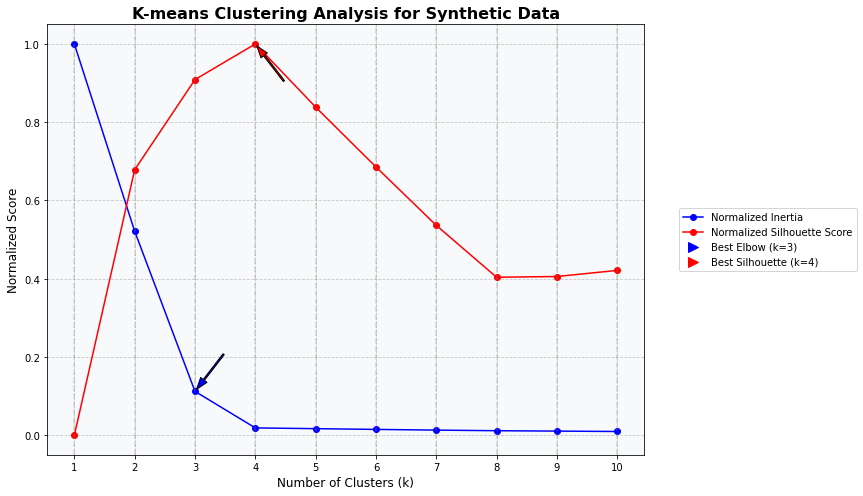


Inertia values:
k=1: 800.00
k=2: 417.20
k=3: 89.69
k=4: 15.00
k=5: 13.43
k=6: 11.92
k=7: 10.48
k=8: 9.26
k=9: 8.45
k=10: 7.65

Silhouette scores:
k=2: 0.5702
k=3: 0.7638
k=4: 0.8403
k=5: 0.7048
k=6: 0.5762
k=7: 0.4507
k=8: 0.3393
k=9: 0.3409
k=10: 0.3540


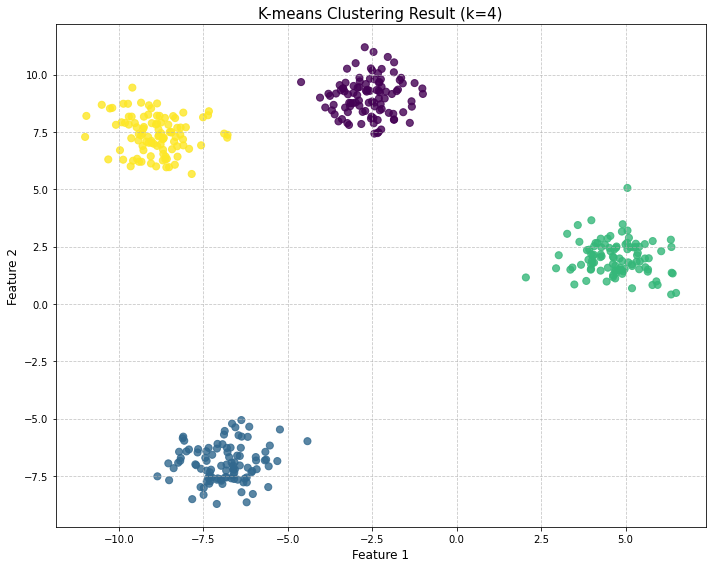


Verification for k=4:
KMeans inertia: 14.9956
Manually calculated inertia: 14.9956


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Create synthetic dataset with 4 natural clusters
X, y = make_blobs(
    n_samples=400, 
    centers=4, 
    cluster_std=0.8, 
    random_state=42
)

# Convert to DataFrame
df = pd.DataFrame(X, columns=['feature1', 'feature2'])

# Print basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(df.head())

# Define the range of cluster sizes to test
cluster_sizes = list(range(1, 11))  # Test k from 1 to 10

# Run the kmeans cluster analysis
fig, ax, inertia_values, silhouette_values = kmeans_cluster_analysis(
    df=df,
    cluster_sizes=cluster_sizes,
    random_state=42,
    standardize=True,  # Standardize the features
    figsize=(12, 7)
)

# Now you can further customize the plot using the ax object
ax.set_facecolor('#f8f9fa')  # Light gray background
ax.set_title('K-means Clustering Analysis for Synthetic Data', fontsize=16, fontweight='bold')

# Display the generated plot
plt.show()

# Print the actual optimal number of clusters (which should be 4 in this case)
print("\nInertia values:")
for k, inertia in zip(cluster_sizes, inertia_values):
    print(f"k={k}: {inertia:.2f}")

print("\nSilhouette scores:")
for k, silhouette in zip(cluster_sizes, silhouette_values):
    if k > 1:  # Silhouette score not defined for k=1
        print(f"k={k}: {silhouette:.4f}")

# Create a scatter plot of the data with the optimal cluster assignment (k=4)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Fit KMeans with k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Create a scatter plot with cluster assignments using fig, ax
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)
ax.set_title('K-means Clustering Result (k=4)', fontsize=15)
ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()

plt.show()

# Verify the implementation by comparing with manually calculated metrics
# For k=4, calculate inertia manually
manual_inertia = 0
for i, point in enumerate(X_scaled):
    centroid = kmeans.cluster_centers_[labels[i]]
    manual_inertia += np.sum((point - centroid) ** 2)

print(f"\nVerification for k=4:")
print(f"KMeans inertia: {kmeans.inertia_:.4f}")
print(f"Manually calculated inertia: {manual_inertia:.4f}")

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()